# Cleaning

In [30]:
# Importing necessary modules
import seaborn as sns
import pyspark.sql.functions as F
import pyspark 
import pandas as pd
import matplotlib.pyplot as plt
from operator import add
from functools import reduce
import numpy as np
import re
import os
from pyspark.sql.types import StructField, StructType, StringType, LongType, FloatType
from pyspark.sql.functions import *
import random
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, StringIndexer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula
import time
import seaborn as sns
from pyspark.sql.types import *

# Setting up visualization
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [31]:
cols_to_keep = [
    "Voters_Gender", # cat
#     "Voters_Age", # num
    "Voters_BirthDate", # ignore
    "Residence_Families_HHCount", # num
    "Residence_HHGender_Description", # cat
    "Mailing_Families_HHCount", # num
    "Mailing_HHGender_Description", # cat

#   !! voter party affiliation
    "Parties_Description", 
    
    # cat
    "CommercialData_PropertyType",
    "AddressDistricts_Change_Changed_CD",
    "AddressDistricts_Change_Changed_SD",
    "AddressDistricts_Change_Changed_HD",
    "AddressDistricts_Change_Changed_County",
    
    "Residence_Addresses_Density", # num
    
    # cat
    "CommercialData_EstimatedHHIncome",
    "CommercialData_ISPSA",
    # num
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_AreaMedianHousingValue",
#    "CommercialData_MosaicZ4Global",
    # cat
     "CommercialData_AreaPcntHHMarriedCoupleNoChild",  
     "CommercialData_AreaPcntHHMarriedCoupleWithChild",
     "CommercialData_AreaPcntHHSpanishSpeaking",
     "CommercialData_AreaPcntHHWithChildren",
     "CommercialData_StateIncomeDecile",
    "Ethnic_Description",
    "EthnicGroups_EthnicGroup1Desc",
    "CommercialData_DwellingType",
    "CommercialData_PresenceOfChildrenCode",
#    "CommercialData_PresenceOfPremCredCrdInHome", ## too many missing
    "CommercialData_DonatesToCharityInHome",
    "CommercialData_DwellingUnitSize",
    "CommercialData_ComputerOwnerInHome",
    "CommercialData_DonatesEnvironmentCauseInHome",
    "CommercialData_Education",
    
#   Don't include because of lookahead bias  
#     "Voters_VotingPerformanceEvenYearGeneral",
#     "Voters_VotingPerformanceEvenYearPrimary",
#     "Voters_VotingPerformanceEvenYearGeneralAndPrimary",
#     "Voters_VotingPerformanceMinorElection",
    
#   Other control variables that expect to be highly associated with outcome:
#     "ElectionReturns_P08CountyTurnoutAllRegisteredVoters",
#     "ElectionReturns_P08CountyTurnoutDemocrats",
#     "ElectionReturns_P08CountyTurnoutRepublicans",
    "General_2000",
    "General_2004",
    "PresidentialPrimary_2000",
    "PresidentialPrimary_2004",
        
#   Outcome variable (indiana law happens in 2005, approved by SCOTUS before presidential election in 2008)
    "General_2008",
## need to remove later
    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters","General_2020",
    "CommercialDataLL_Home_Owner_Or_Renter","Primary_2020","General_2016",
    "Primary_2016","General_2012","Primary_2012","Primary_2008"
]

### FUNCTIONS TO CLEAN DATASET

In [32]:
def clean_numeric_categorical(input_df: DataFrame) -> DataFrame:
    
    # remove special symbols ($, %) from relevant columns
    input_df = input_df.withColumn(
        "CommercialData_AreaMedianHousingValue",
        F.expr("substring(CommercialData_AreaMedianHousingValue, 2, length(CommercialData_AreaMedianHousingValue))"))

    pct = ["CommercialData_AreaPcntHHMarriedCoupleNoChild",  
           "CommercialData_AreaPcntHHMarriedCoupleWithChild",
           "CommercialData_AreaPcntHHSpanishSpeaking",
           "CommercialData_AreaPcntHHWithChildren","ElectionReturns_G08CountyTurnoutAllRegisteredVoters"]

    for c in pct:
        input_df = input_df.withColumn(
            c,
            F.expr(f"substring({c}, 1, length({c})-1)")
        )
    input_df.select(["CommercialData_AreaMedianHousingValue"]+pct).show()

    numeric_cols = [
        'Residence_Families_HHCount',
        'Mailing_Families_HHCount',
        'Residence_Addresses_Density',
        "CommercialData_AreaMedianEducationYears",
        "CommercialData_AreaMedianHousingValue"
    ] + pct

    trinary_cols = [
        'CommercialData_DonatesToCharityInHome',
        'CommercialData_ComputerOwnerInHome',
        'CommercialData_DonatesEnvironmentCauseInHome'
    ]

    binary_cols = []

    dont_touch_cols = [
        "General_2008", 
        "Voters_BirthDate", 
        "General_2000",
        "General_2004",
        "PresidentialPrimary_2000",
        "PresidentialPrimary_2004"
    ]
    
    other_cols = [c for c in input_df.columns if c not in dont_touch_cols]
    other_cols = [c for c in other_cols if c not in (numeric_cols + trinary_cols + binary_cols)]

    categorical_cols = other_cols + binary_cols + trinary_cols

    for c in numeric_cols:
        input_df = input_df.withColumn(c, F.col(c).cast("float").alias(c))
    input_df = input_df.fillna("U", subset= trinary_cols)
    input_df = input_df.fillna("Missing", subset = other_cols)
#   input_df = input_df.fillna("N", subset = binary_cols)
    
    return input_df

In [33]:
def impute_values_function(input_df: DataFrame) -> DataFrame:

    # Create copy of working df
    input_df = input_df.alias('input_df')
    
    pct = ["CommercialData_AreaPcntHHMarriedCoupleNoChild",  
           "CommercialData_AreaPcntHHMarriedCoupleWithChild",
           "CommercialData_AreaPcntHHSpanishSpeaking",
           "CommercialData_AreaPcntHHWithChildren","ElectionReturns_G08CountyTurnoutAllRegisteredVoters"]
    
    numeric_cols = [
        'Residence_Families_HHCount',
        'Mailing_Families_HHCount',
        'Residence_Addresses_Density',
        "CommercialData_AreaMedianEducationYears",
        "CommercialData_AreaMedianHousingValue"
    ] + pct

    trinary_cols = [
        'CommercialData_DonatesToCharityInHome',
        'CommercialData_ComputerOwnerInHome',
        'CommercialData_DonatesEnvironmentCauseInHome'
    ]

    binary_cols = []

    dont_touch_cols = [
        "General_2008", 
        "Voters_BirthDate", 
        "General_2000",
        "General_2004",
        "PresidentialPrimary_2000",
        "PresidentialPrimary_2004"
    ]
    
    other_cols = [c for c in input_df.columns if c not in dont_touch_cols]
    other_cols = [c for c in other_cols if c not in (numeric_cols + trinary_cols + binary_cols)]

    categorical_cols = other_cols + binary_cols + trinary_cols

    # Impute the missing values in the numerical columns with the mean -- minimize change to z-scores of given data
    imputer = Imputer(
        inputCols=numeric_cols, 
        outputCols=["{}_imp".format(c) for c in numeric_cols]
    )

    input_df = imputer.fit(input_df).transform(input_df)

    # Impute categorical columns -- maybe it's better to drop these records
    # input_df = input_df.fillna("missing", subset = categorical_cols)

    indexed_cols = [f"{c}_ind" for c in categorical_cols]

    # Ecode categorical variables
    indexer = StringIndexer(inputCols = categorical_cols, outputCols = indexed_cols)
    input_df = indexer.fit(input_df).transform(input_df)
    
    return input_df

In [34]:
def clean_voter_participation(input_df: DataFrame) -> DataFrame:

    yrs_add = 18
    months_add = 18*12

    # date of national 
    target_month_day_presidential = "11-03"

    # date of presidential primary (ideally we should do this state by state, but this is the date for Indiana's)
    target_month_day_primary = "05-03" 

    input_df = input_df.withColumn("DATE_18", add_months(to_date(col("Voters_BirthDate"),"MM/dd/yyyy"), months_add))
    input_df.select(["Voters_BirthDate", "DATE_18"]).show(10)
    input_df = input_df.dropna(subset = "Voters_BirthDate")
    input_df = input_df.withColumn("YEAR_18", year("DATE_18"))
    input_df = input_df.withColumn("comparator_date_presidential", to_date(concat(col("YEAR_18"), lit("-"), lit(target_month_day_presidential))))
    input_df = input_df.withColumn("comparator_date_primary", to_date(concat(col("YEAR_18"), lit("-"), lit(target_month_day_primary))))

    for election in ["PRESIDENTIAL", "PRIMARY"]:
        input_df = input_df.withColumn(f"YEAR_ELIGIBLE_TO_VOTE_{election}", \
                                    when(col("DATE_18")<=col(f"comparator_date_{election.lower()}"), col("YEAR_18")) \
                                   .otherwise(col("YEAR_18") + 1) \
                                  )

    # check no missing vals:
    input_df.where(col("YEAR_18").isNull()).select("YEAR_18").show(10)

    # get rid of rows where the voter was not old enough to vote in the 2008 general election
    input_df = input_df.filter(col("YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL")<=2008).fillna("N", subset = ["General_2008"])

    # for the 2000 and 2004 general elections, replace with "N" IF the person was old enough to vote at the time

    for election in ["2000", "2004"]:
        input_df = input_df.withColumn(f"General_{election}", \
                                   when((col("YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL")<= int(election)) & \
                                        (col(f"General_{election}").isNull()), "N") \
                                   .otherwise(col(f"General_{election}")) \
                                  )

        input_df = input_df.withColumn(f"PresidentialPrimary_{election}", \
                                   when((col("YEAR_ELIGIBLE_TO_VOTE_PRIMARY")<= int(election)) & \
                                        (col(f"PresidentialPrimary_{election}").isNull()), "N") \
                                   .otherwise(col(f"PresidentialPrimary_{election}")) \
                                  )

    # make the general voting for 2008 a numeric variable; since we've deleted
    # everyone who was not eligible to vote, this can be directly calculated with a 1-0.
    input_df = input_df.withColumn("Voted_General_2008", when(input_df.General_2008 == "Y",1).otherwise(0))
    input_df = input_df.drop("General_2008")
    
    return input_df

In [35]:
# do the same process for Indiana:
indi = spark.read.parquet("gs://pstat135-voter-file/VM2Uniform/VM2Uniform--IN--2021-01-15")
indi = indi.sample(True, 0.1, seed = 19480384)
indi = indi.select(cols_to_keep)
indi = indi.withColumn("STATE", lit("IN"))

indi = clean_numeric_categorical(indi)
indi = impute_values_function(indi)
indi = clean_voter_participation(indi)


+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+---------------------------------------------------+
|CommercialData_AreaMedianHousingValue|CommercialData_AreaPcntHHMarriedCoupleNoChild|CommercialData_AreaPcntHHMarriedCoupleWithChild|CommercialData_AreaPcntHHSpanishSpeaking|CommercialData_AreaPcntHHWithChildren|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+---------------------------------------------------+
|                               139950|                                           40|                                             25|                                       1|                               

+----------------+----------+
|Voters_BirthDate|   DATE_18|
+----------------+----------+
|      05/03/1996|2014-05-03|
|      05/03/1996|2014-05-03|
|      12/04/1959|1977-12-04|
|      11/11/1964|1982-11-11|
|      05/21/1925|1943-05-21|
|      07/22/1998|2016-07-22|
|      03/31/1966|1984-03-31|
|      12/10/1983|2001-12-10|
|      01/05/1977|1995-01-05|
|      05/18/1993|2011-05-18|
+----------------+----------+
only showing top 10 rows



+-------+
|YEAR_18|
+-------+
+-------+



<AxesSubplot:xlabel='CommercialData_AreaMedianHousingValue'>

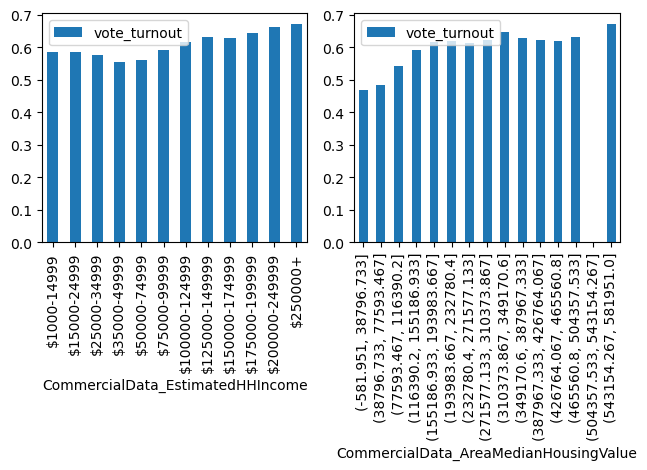

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2)
#plt.rcParams["figure.figsize"] = [7.5, 5]
plt.rcParams["figure.autolayout"] = True

order = ['$1000-14999', '$15000-24999', '$25000-34999','$35000-49999','$50000-74999','$75000-99999','$100000-124999','$125000-149999','$150000-174999','$175000-199999','$200000-249999','$250000+']
q11 = indi.groupBy('CommercialData_EstimatedHHIncome').agg(mean("Voted_General_2008").alias("vote_turnout"))
q11 = q11.select(col("CommercialData_EstimatedHHIncome"), col("vote_turnout").cast(DoubleType()))
q11_df = q11.toPandas()
q11_df = q11_df.set_index('CommercialData_EstimatedHHIncome').loc[order]
q11_df[["vote_turnout"]].plot(ax=axes[0], kind='bar')

q12 = indi.select(col("CommercialData_AreaMedianHousingValue"), col("Voted_General_2008"))
q12 = q12.toPandas()
q12 = q12.sort_values('CommercialData_AreaMedianHousingValue')
bins = pd.cut(q12["CommercialData_AreaMedianHousingValue"], 15)
q12 = q12.groupby(bins).agg(vote_turnout=('Voted_General_2008', 'mean'))
q12[["vote_turnout"]].plot(ax=axes[1], kind='bar')


<AxesSubplot:xlabel='Ethnic_Description'>

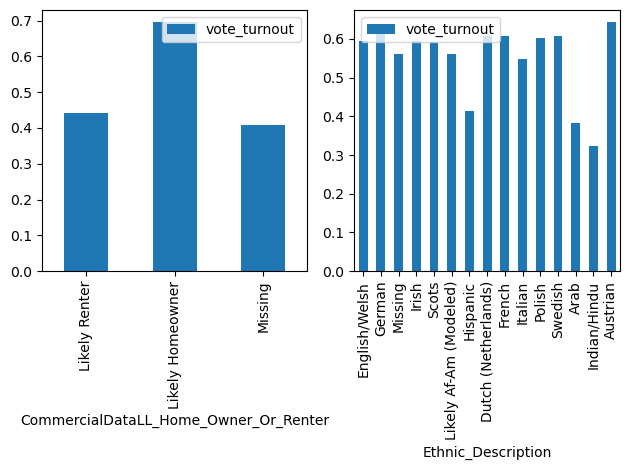

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2)

plt.rcParams["figure.autolayout"] = True
q13 = indi.groupBy('CommercialDataLL_Home_Owner_Or_Renter').agg(mean("Voted_General_2008").alias("vote_turnout"))
q13 = q13.select(col("CommercialDataLL_Home_Owner_Or_Renter"), col("vote_turnout").cast(DoubleType()))
q13_df = q13.toPandas().set_index('CommercialDataLL_Home_Owner_Or_Renter')
#q13_df.plot.bar(x="CommercialDataLL_Home_Owner_Or_Renter", y="vote_turnout")
q13_df[["vote_turnout"]].plot(ax=axes[0], kind='bar')
qe = indi.select(col("Ethnic_Description"), col("Voted_General_2008"))

qe = qe.toPandas()
qe = qe.groupby("Ethnic_Description").agg({"Voted_General_2008" :'mean',"Ethnic_Description": "count"})
qe = qe.rename(columns={
    "Voted_General_2008": "vote_turnout", "Ethnic_Description": "countnum"}).sort_values(['countnum'],ascending=False).head(15)
qe[["vote_turnout"]].plot(ax=axes[1], kind='bar')

+---------------------------------------+
|CommercialData_AreaMedianEducationYears|
+---------------------------------------+
|                                   null|
|                                   12.0|
|                                   null|
|                                   12.0|
|                                   12.0|
|                                   12.0|
|                                   12.0|
|                                   12.0|
|                                   12.0|
|                                   12.0|
|                                   12.0|
|                                   12.0|
|                                   12.0|
|                                   12.0|
+---------------------------------------+
only showing top 14 rows



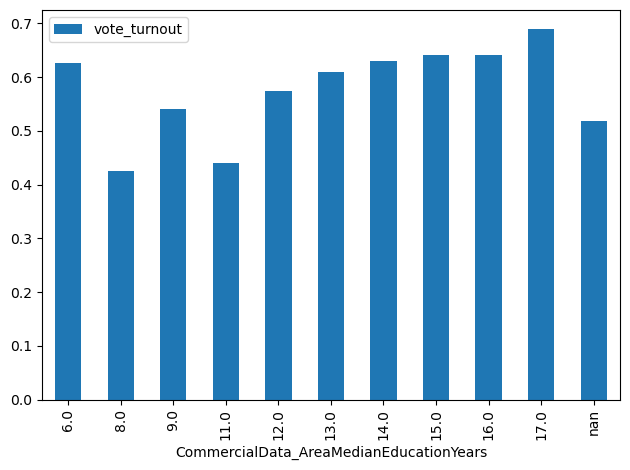

In [38]:
indi.select('CommercialData_AreaMedianEducationYears').show(14)
q13 = indi.groupBy('CommercialData_AreaMedianEducationYears').agg(mean("Voted_General_2008").alias("vote_turnout"))
q13 = q13.select(col("CommercialData_AreaMedianEducationYears"), col("vote_turnout").cast(DoubleType()))
q13_df = q13.toPandas()
q13_df = q13_df.sort_values(['CommercialData_AreaMedianEducationYears'],ascending=True)
q13_df.plot.bar(x="CommercialData_AreaMedianEducationYears", y="vote_turnout")
plt.show()

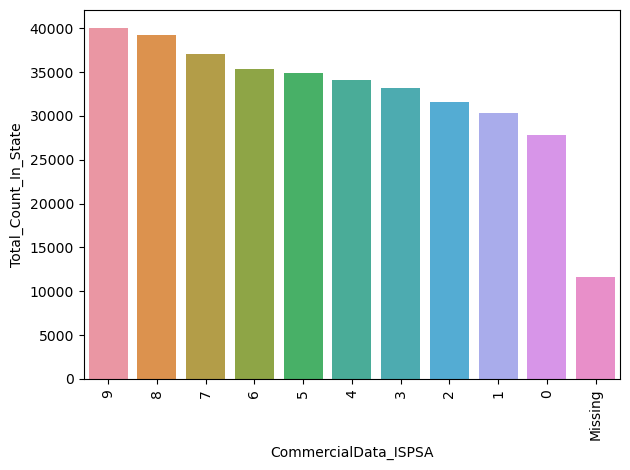

In [39]:
activitiesbyispsa_indi = indi.groupBy('CommercialData_ISPSA')\
.agg(F.count('CommercialData_ISPSA').alias("Total_Count_In_State"))\
.orderBy(F.desc("Total_Count_In_State")).toPandas()
sns.barplot(x="CommercialData_ISPSA",y="Total_Count_In_State",
data=activitiesbyispsa_indi)
plt.xticks(rotation=90)
plt.show()


In [40]:
def _getISPSAByYear(df, year):
    df1 = df.fillna("N/A", subset = [f"General_{year}", f"Primary_{year}", "CommercialData_ISPSA"])\
    .groupBy(
        F.col("CommercialData_ISPSA").alias("ISPSA"),
        F.col(f"General_{year}").alias("Voted_General"),
        F.col(f"Primary_{year}").alias("Voted_Primary")
    ).count()\
    .withColumnRenamed("count",
                       f"Participation_{year}")\
    .join(
        df.select("CommercialData_ISPSA").fillna("N/A")\
            .groupBy(
                F.col("CommercialData_ISPSA").alias("ISPSA")
            ).count(),
        on = "ISPSA",
        how = "left"
    )\
    .withColumnRenamed("count", "Total_Voters_By_ISPSA")\
    .withColumn(
        f"Pct_Participation_{year}",
        F.round(
            F.col(f"Participation_{year}")/F.col("Total_Voters_By_ISPSA") *100,
            2
        ))\
    .drop("Total_Voters_By_ISPSA")
    
    df1 = df1.join(
        df1.groupBy("Voted_General", "Voted_Primary").count()\
        .withColumn('Voted_In_Election',
                    F.when((F.col("Voted_General") == 'Y') & 
                           (F.col("Voted_Primary") == 'Y'),"Both")\
                    .when((F.col("Voted_General") == 'N/A') & 
                          (F.col("Voted_Primary") == 'N/A'), "Neither")\
                    .when((F.col("Voted_General") == 'Y') & 
                          (F.col("Voted_Primary") == 'N/A'), "Only General")\
                    .otherwise("Only Primary")
                    )\
        .drop("count"),
        on = ["Voted_General", "Voted_Primary"],
        how = "left"
    ).drop("Voted_General", "Voted_Primary")\
    .orderBy(F.col("ISPSA"), F.col(f"Voted_In_Election"))
    return df1
    
def getISPSAByYears(df, years):
    dfs = [_getISPSAByYear(df, y) for y in years]
    return (
        reduce(lambda left, right: left.join(right, on=['ISPSA','Voted_In_Election'], 
                                             how = "left"), dfs)\
        .orderBy(F.col("ISPSA"),F.col('Voted_In_Election'))
    )
ispsa_data = getISPSAByYears(indi, [2020,2016,2012])
pattern = re.compile("^Part.*")
to_drop = [c for c in ispsa_data.columns if pattern.match(c)]
ispsa_data = ispsa_data.drop(*to_drop)

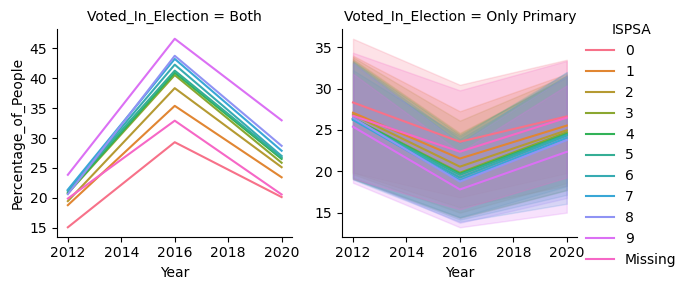

In [41]:
merged_id_df = ispsa_data.toPandas().melt(
    id_vars = ["ISPSA", "Voted_In_Election"],
    var_name = "Year",
    value_name = "Percentage_of_People"
)
merged_id_df = spark.createDataFrame(merged_id_df)
df = merged_id_df.withColumn('Year', F.regexp_replace(F.col("Year"),
                                                      "Pct_Participation_", "").cast("integer"))
df1 = df.toPandas()
g = sns.FacetGrid(df1, col="Voted_In_Election", hue = "ISPSA",
                  col_wrap = 2, sharey = False)
g.map_dataframe(sns.lineplot, x="Year",y="Percentage_of_People")
g.add_legend()
plt.show();

In [42]:
def _getEthnicParticipationByYear(df, year):
    df1 = df.fillna("N/A", subset = [f"General_{year}", f"Primary_{year}", "EthnicGroups_EthnicGroup1Desc"])\
    .groupBy(
        F.col("EthnicGroups_EthnicGroup1Desc").alias("Ethnic_Descent"),
        F.col(f"General_{year}").alias("Voted_General"),
        F.col(f"Primary_{year}").alias("Voted_Primary")
    ).count()\
    .withColumnRenamed("count",
                       f"Participation_{year}")\
    .join(
        df.select("EthnicGroups_EthnicGroup1Desc").fillna("N/A")\
            .groupBy(
                F.col("EthnicGroups_EthnicGroup1Desc").alias("Ethnic_Descent")
            ).count(),
        on = "Ethnic_Descent",
        how = "left"
    )\
    .withColumnRenamed("count", "Total_Voters_By_Ethnic")\
    .withColumn(
        f"Pct_Participation_{year}",
        F.round(
            F.col(f"Participation_{year}")/F.col("Total_Voters_By_Ethnic") *100,
            2
        ))\
    .drop("Total_Voters_By_Enthic")
    
    df1 = df1.join(
        df1.groupBy("Voted_General", "Voted_Primary").count()\
        .withColumn('Voted_In_Election',
                    F.when((F.col("Voted_General") == 'Y') & 
                           (F.col("Voted_Primary") == 'Y'),"Both")\
                    .when((F.col("Voted_General") == 'N/A') & 
                          (F.col("Voted_Primary") == 'N/A'), "Neither")\
                    .when((F.col("Voted_General") == 'Y') & 
                          (F.col("Voted_Primary") == 'N/A'), "Only General")\
                    .otherwise("Only Primary")
                    )\
        .drop("count"),
        on = ["Voted_General", "Voted_Primary"],
        how = "left"
    ).drop("Voted_General", "Voted_Primary")\
    .orderBy(F.col("Ethnic_Descent"), F.col(f"Voted_In_Election"))
    return df1
    
def getEthnicParticipationByYears(df, years):
    dfs = [_getEthnicParticipationByYear(df, y) for y in years]
    return (
        reduce(lambda left, right: left.join(right, on=['Ethnic_Descent','Voted_In_Election'], 
                                             how = "left"), dfs)\
        .orderBy(F.col("Ethnic_Descent"),F.col('Voted_In_Election'))
    )

In [43]:
ethnic_data = getEthnicParticipationByYears(indi, [2020,2016,2012])
pattern = re.compile("^Part.*")
to_drop = [c for c in ethnic_data.columns if pattern.match(c)]
ethnic_data = ethnic_data.drop(*to_drop)

In [ ]:
merged_ed_df = ethnic_data.toPandas().melt(
    id_vars = ["Ethnic_Descent", "Voted_In_Election"],
    var_name = "Year",
    value_name = "Percentage_of_People"
)
merged_ed_df = spark.createDataFrame(merged_ed_df)
df = merged_ed_df.withColumn('Year', F.regexp_replace(F.col("Year"),
                                                      "Pct_Participation_", "").cast("integer"))
df1 = df.toPandas()
g = sns.FacetGrid(df1, col="Voted_In_Election", hue = "Ethnic_Descent",
                  col_wrap = 2, sharey = False)
g.map_dataframe(sns.lineplot, x="Year",y="Percentage_of_People")
g.add_legend()
plt.show()